# Load modules and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
sys.path.append("../src/")

from lbd_functions import printtimelogwithstarline,printtimelog
from utils import get_ecdf_area_difference, get_ecdf, interpolate_ecdf, interp_ecdf_normalize_x
from utils import get_spherical_coordinate_from_proportions, get_proportions_from_spherical_coordinates
from utils import get_best_fitting_plane,get_Z_from_plane_coeffs,remove_trend_from_data

import geostatspy.GSLIB as GSLIB                       # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                 # GSLIB methods convert to Python

df_summary = pd.read_csv('../data/boreholes-processed/LBW_extended_STRATA_LOG_summary.csv')
df_classified_log_fn = '../data/boreholes-processed/LBW_extended_STRATA_LOG_classified.csv'

def get_df_2D_prop(df_2D_proportions_level_0,level_0_name,df_summary):
    ix_2D_prop = np.asarray(np.where(df_2D_proportions_level_0['level_0']==level_0_name)).flatten()
    df_2D_prop = df_summary[['RN','Easting','Northing']].copy()
    df_2D_prop = df_summary[['RN','Easting','Northing']].join(df_2D_proportions_level_0.loc[ix_2D_prop,['RN','proportion']].set_index('RN'),on='RN',how='outer')
    ixtmp = np.asarray(np.where(df_2D_prop['proportion'].isnull())).flatten()
    df_2D_prop.loc[ixtmp,'proportion']=0.0
    return df_2D_prop 

def add_nst_cols(df_2D_prop, colname, plot=False):
    # NORMAL SCORE TRANSFORM
    df_2D_prop['tv_'+colname] = np.nan
    df_2D_prop['tns_'+colname] = np.nan
    df_2D_prop['nst_'+colname] = np.nan
    df_2D_prop.loc[:,'nst_'+colname], df_2D_prop.loc[:,'tv_'+colname], df_2D_prop.loc[:,'tns_'+colname] = geostats.nscore(df_2D_prop, colname)
    if plot:
        # check plot
        plt.figure(dpi=100)
        plt.hist(df_2D_prop.loc[:,'nst_'+colname], bins=20)
        plt.title('histrogram of Normal Score Transformed '+colname)
        plt.show()
    return

def get_varmap(df_2D_prop,colname,lag_nb,lag_width):
    vmap, _ = geostats.varmapv(df_2D_prop,'Easting','Northing',colname,tmin=-999,tmax=999,nxlag=lag_nb,nylag=lag_nb,dxlag=lag_width,dylag=lag_width,minnp=1,isill=1)
    nanidx_sand = np.where(vmap==-999)
    vmap[nanidx_sand]=np.nan
    return vmap


In [2]:
df_processed_log = pd.read_csv(df_classified_log_fn)

ix_sediments = np.asarray(np.where(
    (df_processed_log['level_0']!='Basement') & 
    (df_processed_log['level_0']!='Weathered basement')
)).flatten()


### Proportion estimation

In [3]:
# 2D proportions - prop average by drillhole
df_2D_proportions_level_0 = df_processed_log.loc[ix_sediments,['RN','level_0','thickness']].groupby(['RN','level_0'],as_index=False).sum()
df_bh_thickness = df_2D_proportions_level_0.groupby(['RN'],as_index=False).sum() #.rename(columns = {'thickness': 'bh_thickness'})
df_2D_proportions_level_0 = df_2D_proportions_level_0.join(df_bh_thickness.set_index('RN'),on='RN', how='left', lsuffix='',rsuffix='_bh')
df_2D_proportions_level_0['proportion'] = df_2D_proportions_level_0['thickness']/df_2D_proportions_level_0['thickness_bh']

# TO GET ONE ROW PER BOREHOLE, EVEN IF PROPORTION==0
df_2D_prop_clay = get_df_2D_prop(df_2D_proportions_level_0,'Clay',df_summary)
df_2D_prop_sand = get_df_2D_prop(df_2D_proportions_level_0,'Sands',df_summary)
df_2D_prop_inte = get_df_2D_prop(df_2D_proportions_level_0,'Intermediate',df_summary)

df_2D_prop_clay.rename(columns={'proportion': 'prop_clay'},inplace=True)
df_2D_prop_sand.rename(columns={'proportion': 'prop_sand'},inplace=True)
df_2D_prop_inte.rename(columns={'proportion': 'prop_inte'},inplace=True)

df_2D_prop = df_2D_prop_clay.join(df_2D_prop_sand[['RN','prop_sand']].set_index('RN'),on='RN', how='left').join(
    df_2D_prop_inte[['RN','prop_inte']].set_index('RN'),on='RN', how='left')

# We do the following to indentify incomplete data only (not the most direct way, but it works)
df_2D_prop['theta'],df_2D_prop['phi'] = get_spherical_coordinate_from_proportions(df_2D_prop['prop_clay'].values,
                                                                                  df_2D_prop['prop_sand'].values,
                                                                                  df_2D_prop['prop_inte'].values)

ix = np.asarray(np.where(df_2D_prop['phi'].isnull() | df_2D_prop['theta'].isnull())).flatten()
#df_2D_prop.iloc[ix,:]
df_2D_prop.drop(ix,inplace=True)
df_2D_prop.reset_index(drop=True,inplace=True)

df_2D_prop.to_csv('../data/boreholes-processed/spatial-proportions.csv')


C:\Users\00102908\my-UWA\LowerBurdekinDelta\notebooks\../src\utils.py:176: RuntimeWarning: invalid value encountered in divide
  x = np.sqrt(p1/psum)
C:\Users\00102908\my-UWA\LowerBurdekinDelta\notebooks\../src\utils.py:177: RuntimeWarning: invalid value encountered in divide
  y = np.sqrt(p2/psum)
C:\Users\00102908\my-UWA\LowerBurdekinDelta\notebooks\../src\utils.py:178: RuntimeWarning: invalid value encountered in divide
  z = np.sqrt(p3/psum)


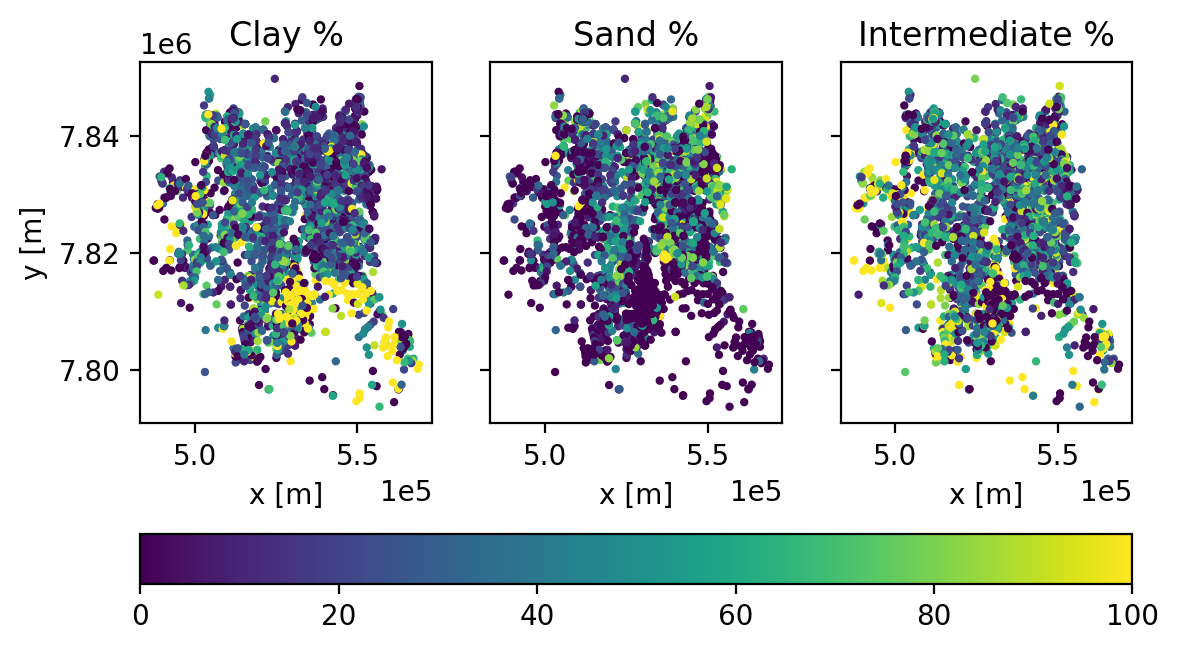

In [4]:
df_2D_prop = pd.read_csv('../data/boreholes-processed/spatial-proportions.csv')

scilim_x = 5
scilim_y = 6

aspectr = 1.8

s=4
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('Clay %')
im0=ax[0].scatter(df_2D_prop['Easting'].values,
                  df_2D_prop['Northing'].values,
                  c = df_2D_prop['prop_clay'].values*1E2,
                  cmap='viridis',s=s)
ax[0].set_aspect(aspectr)
ax[0].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[0].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[0].set_xlabel('x [m]')
ax[0].set_ylabel('y [m]')
# fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('Sand %')
im1=ax[1].scatter(df_2D_prop['Easting'].values,
                  df_2D_prop['Northing'].values,
                  c = df_2D_prop['prop_sand'].values*1E2,
                  cmap='viridis',s=s)
ax[1].set_aspect(aspectr)
ax[1].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[1].set_xlabel('x [m]')
# ax[1].set_ylabel('y [m]')
# fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('Intermediate %')
im2=ax[2].scatter(df_2D_prop['Easting'].values,
                  df_2D_prop['Northing'].values,
                  c = df_2D_prop['prop_inte'].values*1E2,
                  cmap='viridis',s=s)
ax[2].set_aspect(aspectr)
ax[2].ticklabel_format(style='sci', axis='x', scilimits=(scilim_x,scilim_x))
ax[2].ticklabel_format(style='sci', axis='y', scilimits=(scilim_y,scilim_y))
ax[2].set_xlabel('x [m]')
# ax[2].set_ylabel('y [m]')
# fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

fig.colorbar(im0,ax=ax, orientation='horizontal', fraction=.1) #images[0], 
plt.show()

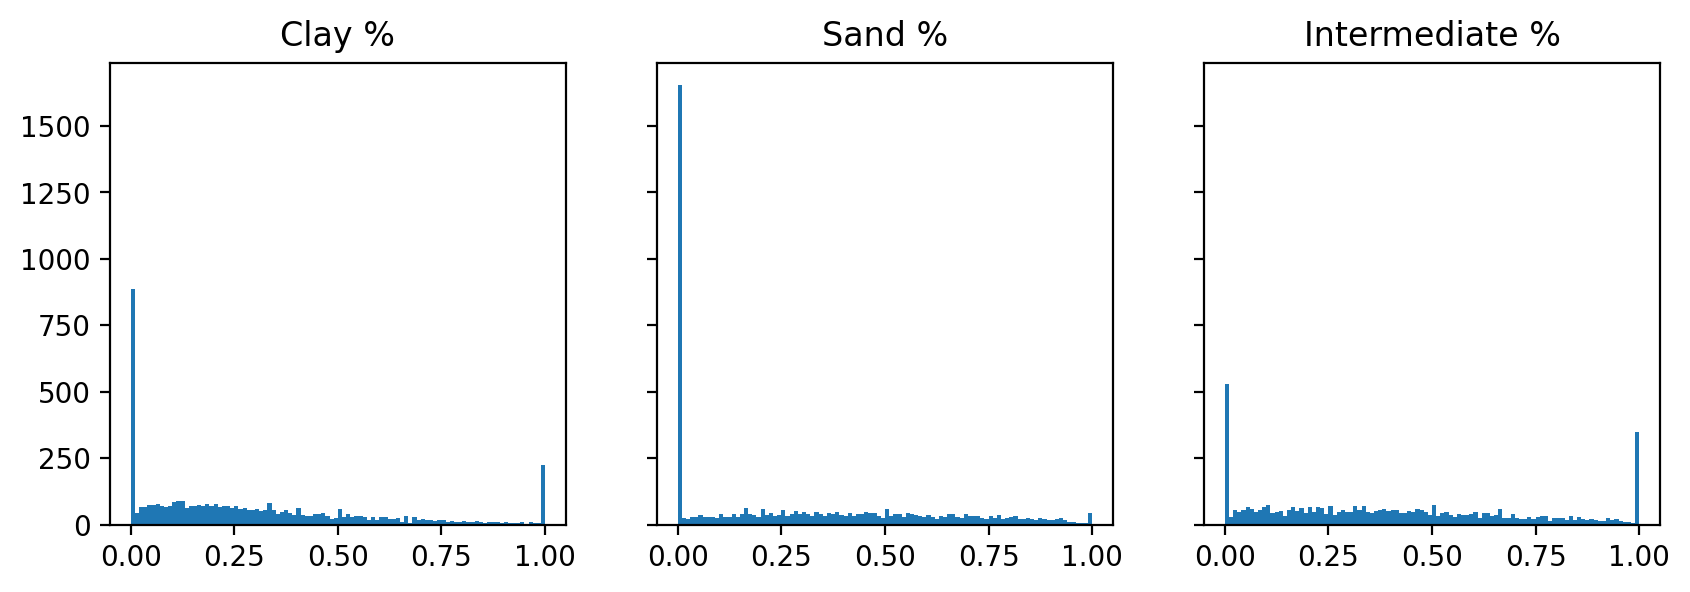

In [5]:
nbins=100
fig,ax = plt.subplots(1,3,dpi=200,sharey=True,figsize=(10,3))
ax[0].set_title('Clay %')
ax[0].hist(df_2D_prop['prop_clay'].values,nbins)
ax[1].set_title('Sand %')
ax[1].hist(df_2D_prop['prop_sand'].values,nbins)
ax[2].set_title('Intermediate %')
ax[2].hist(df_2D_prop['prop_inte'].values,nbins)
plt.show()

### Semi-variogram analysis

In [6]:
# FIND PLANAR TREND
xmin = 52.5*1E4
xmax = 56*1E4
ymin= 781*1E4
ymax = 785*1E4

dx = dy = 250
nx = np.round((xmax-xmin)/dx).astype(int)
ny = np.round((ymax-ymin)/dy).astype(int)

xvec = np.linspace(xmin+dx/2,xmax-dx/2,num=nx,endpoint=True)
yvec = np.linspace(ymin+dy/2,ymax-dy/2,num=ny,endpoint=True)
X,Y = np.meshgrid(xvec,yvec)

plane_coeffs_clay_prop = get_best_fitting_plane(df_2D_prop,'prop_clay')
trend_clay_prop = get_Z_from_plane_coeffs(X,Y,plane_coeffs_clay_prop)
df_2D_prop['clay_dtd'] = remove_trend_from_data(df_2D_prop,'prop_clay',plane_coeffs_clay_prop)

plane_coeffs_sand_prop = get_best_fitting_plane(df_2D_prop,'prop_sand')
trend_sand_prop = get_Z_from_plane_coeffs(X,Y,plane_coeffs_sand_prop)
df_2D_prop['sand_dtd'] = remove_trend_from_data(df_2D_prop,'prop_sand',plane_coeffs_sand_prop)

plane_coeffs_inte_prop = get_best_fitting_plane(df_2D_prop,'prop_inte')
trend_inte_prop = get_Z_from_plane_coeffs(X,Y,plane_coeffs_inte_prop)
df_2D_prop['inte_dtd'] = remove_trend_from_data(df_2D_prop,'prop_inte',plane_coeffs_inte_prop)


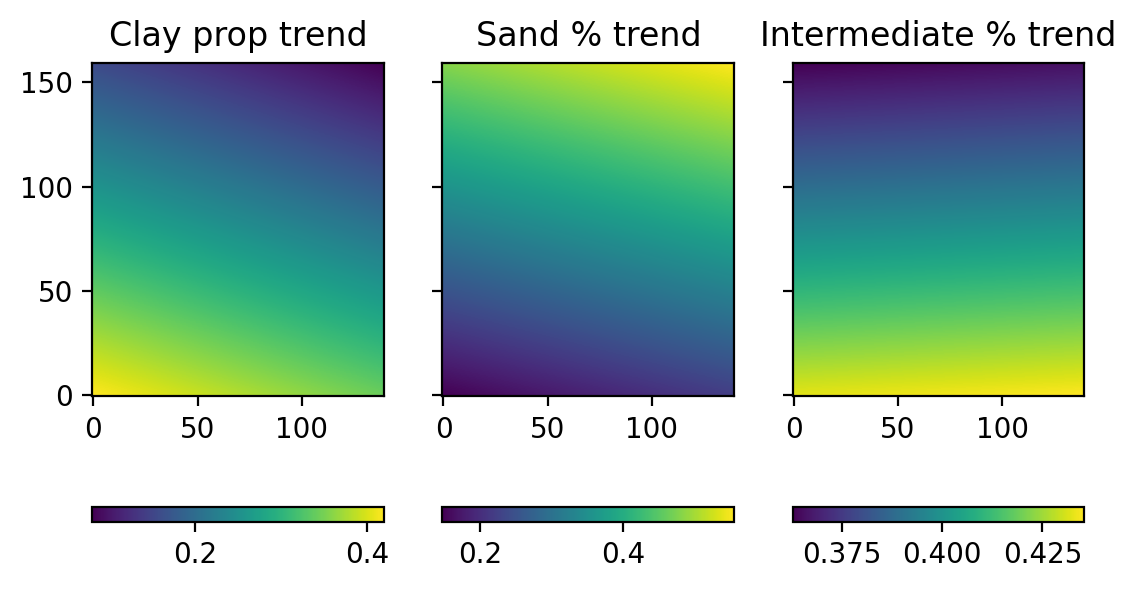

In [7]:
# PLOT PLANAR TREND
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('Clay prop trend')
im0=ax[0].imshow(trend_clay_prop, origin='lower', cmap='viridis')
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('Sand % trend')
im1=ax[1].imshow(trend_sand_prop, origin='lower', cmap='viridis')
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('Intermediate % trend')
im2=ax[2].imshow(trend_inte_prop, origin='lower', cmap='viridis')
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

plt.show()

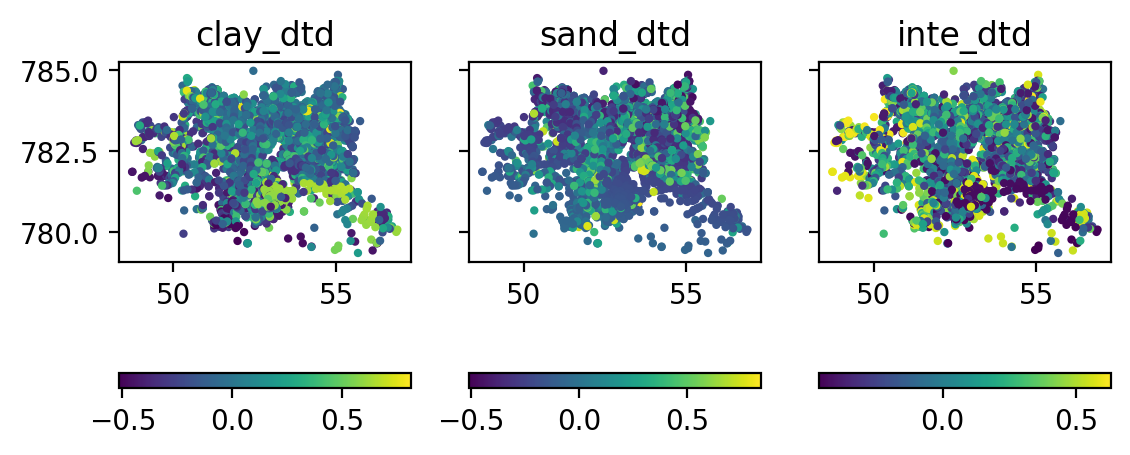

In [8]:
# PLOT DETRENDED DATA
s=4
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('clay_dtd')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['clay_dtd'].values,
                  cmap='viridis',s=s)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('sand_dtd')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['sand_dtd'].values,
                  cmap='viridis',s=s)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('inte_dtd')
im2=ax[2].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['inte_dtd'].values,
                  cmap='viridis',s=s)
ax[2].set_aspect(1)
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

plt.show()

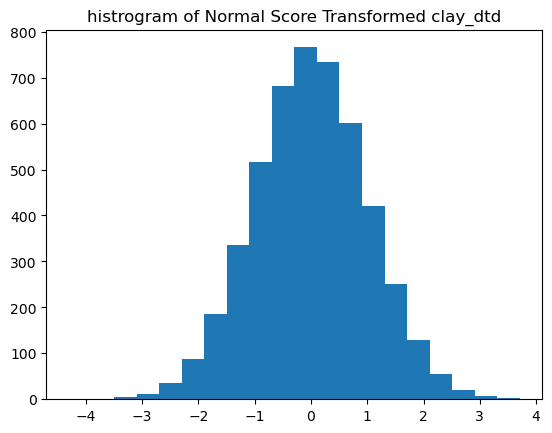

In [9]:
# NORMAL SCORE TRANSFORM
add_nst_cols(df_2D_prop,'clay_dtd',plot=True)
add_nst_cols(df_2D_prop,'sand_dtd')
add_nst_cols(df_2D_prop,'inte_dtd')

In [10]:
df_2D_prop

,Unnamed: 0,RN,Easting,Northing,prop_clay,prop_sand,prop_inte,theta,phi,clay_dtd,...,inte_dtd,tv_clay_dtd,tns_clay_dtd,nst_clay_dtd,tv_sand_dtd,tns_sand_dtd,nst_sand_dtd,tv_inte_dtd,tns_inte_dtd,nst_inte_dtd
0,0,20917,526047.920,7816871.202,0.711712,0.288288,0.000000,1.570796,0.566788,0.338381,...,-0.420611,-0.516467,-3.710949,1.125503,-0.507284,-3.710949,0.347981,-0.461717,-3.710949,-1.687682
1,1,20921,528027.083,7842476.233,0.509810,0.362818,0.127372,1.205857,0.700771,0.310591,...,-0.248502,-0.500213,-3.422952,1.057882,-0.503836,-3.422952,0.013457,-0.460896,-3.422952,-0.635522
2,2,20922,524216.073,7820972.989,0.100281,0.814433,0.085286,1.274440,1.233321,-0.249905,...,-0.327968,-0.497603,-3.281540,-0.973777,-0.500028,-3.281540,1.914596,-0.459490,-3.281540,-0.928220
3,3,20923,527924.188,7820920.088,0.518530,0.397934,0.083536,1.277587,0.719413,0.176185,...,-0.330140,-0.496457,-3.185431,0.726924,-0.499913,-3.185431,0.532972,-0.459161,-3.185431,-0.937818
4,4,20925,523511.176,7817625.662,0.118750,0.881250,0.000000,1.570796,1.218982,-0.255184,...,-0.419062,-0.493911,-3.111983,-1.013633,-0.499913,-3.111983,2.483537,-0.457122,-3.111983,-1.679143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,4838,12100517,549841.859,7815890.070,0.190000,0.700000,0.110000,1.232731,1.090500,-0.137265,...,-0.314448,0.769987,3.111983,-0.351282,0.765836,3.111983,1.350186,0.623634,3.111983,-0.863282
4839,4839,12100518,541963.563,7818005.436,0.308108,0.513514,0.178378,1.134761,0.911738,-0.022540,...,-0.241658,0.774878,3.185431,0.117762,0.783450,3.185431,0.782668,0.626302,3.185431,-0.607271
4840,4840,12100519,542105.282,7819134.048,0.228571,0.771429,0.000000,1.570796,1.072316,-0.094282,...,-0.418070,0.775136,3.281540,-0.171640,0.826657,3.281540,1.601665,0.628385,3.281540,-1.652205
4841,4841,12100520,540754.172,7819932.169,0.250000,0.486364,0.263636,1.031590,0.948784,-0.070548,...,-0.152913,0.775784,3.422952,-0.065780,0.828929,3.422952,0.692962,0.628385,3.422952,-0.315714


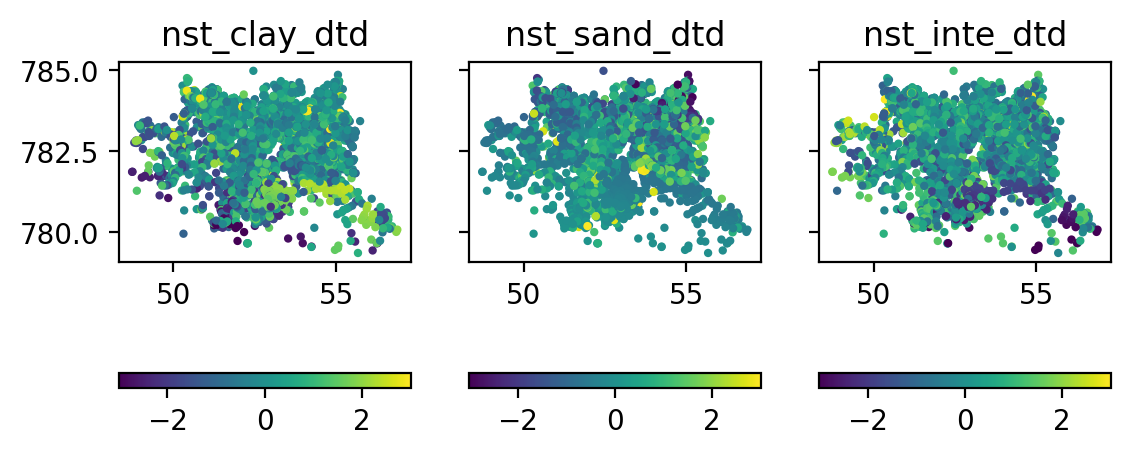

In [11]:
# PLOT DETRENDED DATA
s=4
fig,ax = plt.subplots(1,3,dpi=200,sharey=True)
ax[0].set_title('nst_clay_dtd')
im0=ax[0].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_clay_dtd'].values,
                  cmap='viridis',s=s,vmin=-3,vmax=+3)
ax[0].set_aspect(1)
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

ax[1].set_title('nst_sand_dtd')
im1=ax[1].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_sand_dtd'].values,
                  cmap='viridis',s=s,vmin=-3,vmax=+3)
ax[1].set_aspect(1)
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

ax[2].set_title('nst_inte_dtd')
im2=ax[2].scatter(df_2D_prop['Easting'].values/1E4,
                  df_2D_prop['Northing'].values/1E4,
                  c = df_2D_prop['nst_inte_dtd'].values,
                  cmap='viridis',s=s,vmin=-3,vmax=+3)
ax[2].set_aspect(1)
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)

plt.show()

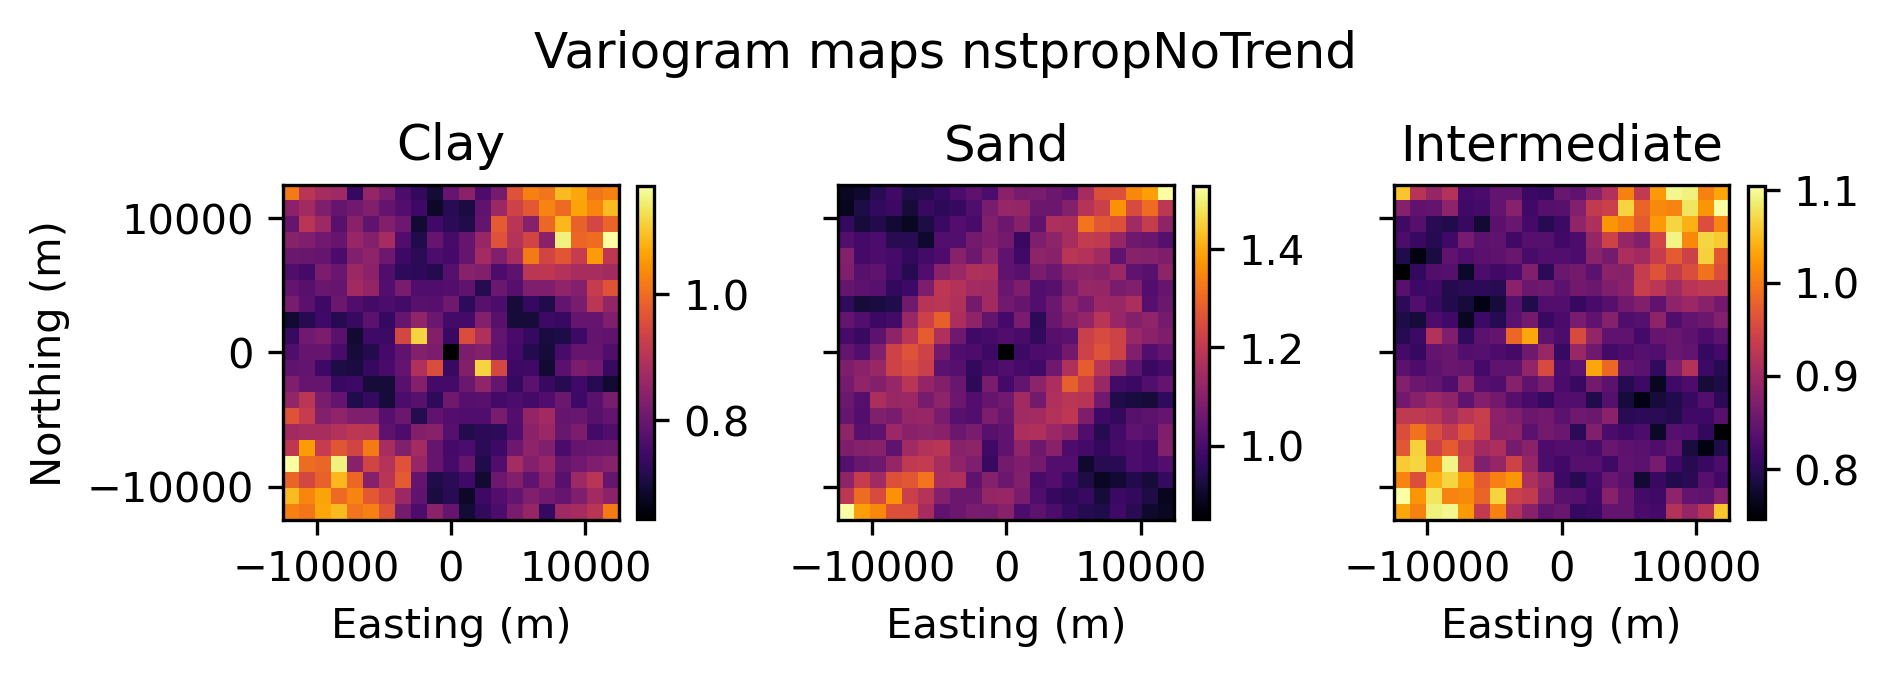

In [12]:
# Semi-variogram analysis

#%% Variogram maps of detrended and normal score transformed data
lag_nb = 10
dmax = ((xmax-xmin)+(ymax-ymin))/6
lag_width = dmax/lag_nb

vmap_clay = get_varmap(df_2D_prop,'nst_clay_dtd',lag_nb,lag_width)
vmap_sand = get_varmap(df_2D_prop,'nst_sand_dtd',lag_nb,lag_width)
vmap_inte = get_varmap(df_2D_prop,'nst_inte_dtd',lag_nb,lag_width)

# PLOT VARIOGRAM MAPS
leftextent = -lag_width*lag_nb
rightextent = lag_width*lag_nb
bottomextent = -lag_width*lag_nb
topextent = lag_width*lag_nb
extent = (leftextent,rightextent,bottomextent,topextent)

fig,ax = plt.subplots(1,3,dpi=300,sharey=True)
im0 = ax[0].imshow(vmap_clay,extent=extent,cmap='inferno')
ax[0].set_title('Clay')
ax[0].set_xlabel('Easting (m)')
ax[0].set_ylabel('Northing (m)')
fig.colorbar(im0,ax=ax[0],orientation='vertical', fraction=.045)

im1 = ax[1].imshow(vmap_sand,extent=extent,cmap='inferno')
ax[1].set_title('Sand')
ax[1].set_xlabel('Easting (m)')
fig.colorbar(im1,ax=ax[1],orientation='vertical', fraction=.045)

im2 = ax[2].imshow(vmap_inte,extent=extent,cmap='inferno')
ax[2].set_title('Intermediate')
ax[2].set_xlabel('Easting (m)')
fig.colorbar(im2,ax=ax[2],orientation='vertical', fraction=.045)

fig.suptitle('Variogram maps nstpropNoTrend')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(top=1.45)
plt.show()


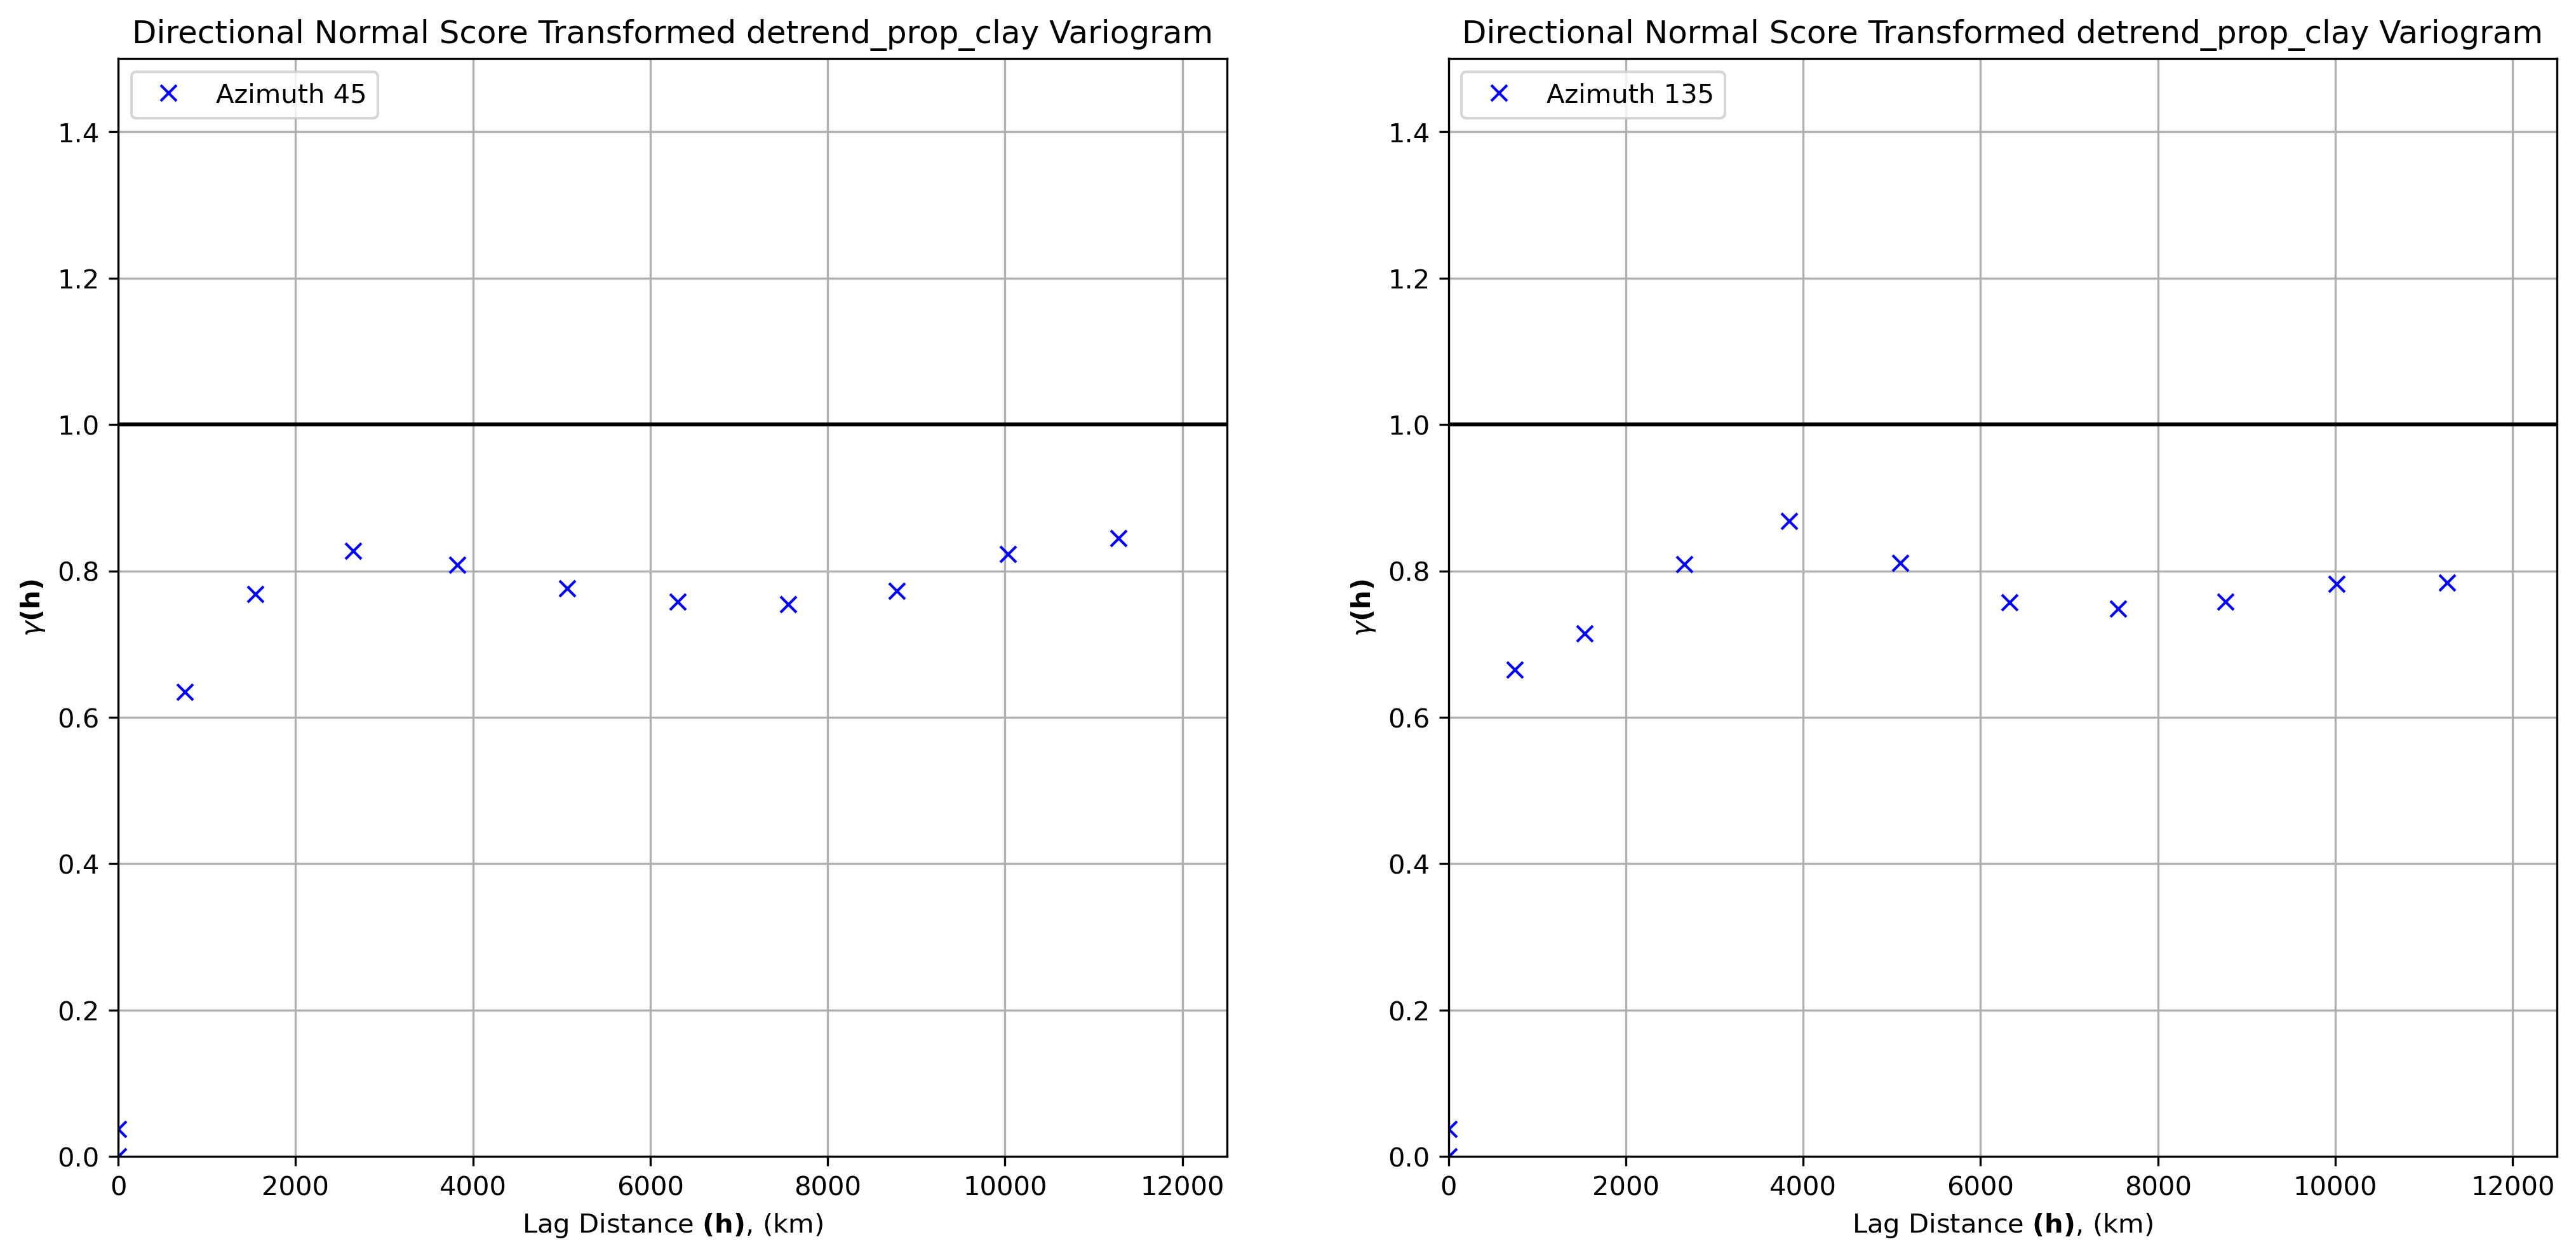

In [13]:
#%% ANISOTROPIC EXPERIMENTAL VARIOGRAM
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 45                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

# Arrays to store the results
lag_clay = np.zeros((len(azi_mat),nlag+1)); 
gamma_clay = np.zeros((len(azi_mat),nlag+1)); 
npp_clay = np.zeros((len(azi_mat),nlag+1));

plt.figure(dpi=300)
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_clay[iazi,:], gamma_clay[iazi,:], npp_clay[iazi,:] = geostats.gamv(df_2D_prop,'Easting','Northing','nst_clay_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_clay[iazi,:],gamma_clay[iazi,:],'x',color = 'blue',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,lag_dist*nlag],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional Normal Score Transformed detrend_prop_clay Variogram')
    plt.xlim([0,lag_dist*nlag])
    plt.ylim([0,1.5])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()


In [17]:
lag_clay = gamma_clay = npp_clay = 0

iazi = 0
lag_clay, gamma_clay, npp_clay = geostats.gamv(df_2D_prop,'Easting','Northing','nst_clay_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)

print('nlag: '+str(nlag))
print('lag_dist: '+str(lag_dist))

print('lag_clay: '+str(lag_clay))
print('gamma_clay: '+str(gamma_clay))
print('npp_clay: '+str(npp_clay))

nlag: 10
lag_dist: 1250.0
lag_clay: [    0.           751.44414195  1545.47513742  2645.7275797
  3820.72105698  5061.67890295  6306.36536984  7554.37090621
  8779.98531615 10030.24773677 11281.43405981     0.        ]
gamma_clay: [0.03708492 0.63510176 0.76817536 0.82750325 0.80864581 0.77656359
 0.7578542  0.754132   0.7730621  0.82325316 0.84457527 0.        ]
npp_clay: [  5259.  62704. 192598. 315636. 404490. 470852. 537880. 609734. 670784.
 722260. 782922.      0.]


In [ ]:
#%% ANISTOROPIC VARIOGRAM FITTING
nug = 0.04; nst = 2                                             # 2 nest structure variogram model parameters
it1 = 2; cc1 = 0.63; azi1 = 45; hmaj1 = 600; hmin1 = 400
# it1 = 2; cc1 = 0.96; azi1 = 45; hmaj1 = 4000; hmin1 = 2500
it2 = 3; cc2 = 0.33; azi2 = 45; hmaj2 = 5500; hmin2 = 3500

vario_clay = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object )#
xlag = 100; nlag = 120; 
azm = 45;                                # project the model in the 045 azimuth
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario_clay)
azm = 135                                                      # project the model in the 135 azimuth
index135,h135,gam135,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario_clay)

plt.figure(dpi=300)
plt.subplot(1,2,1)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'blue')
plt.plot(lag_clay[0,:],gamma_clay[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Normal Score Transformed detrend_prop_clay Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'blue')
plt.plot(lag_clay[1,:],gamma_clay[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Normal Score Transformed detrend_prop_clay Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
#%% ANISOTROPIC EXPERIMENTAL VARIOGRAM SAND
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 45                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 45                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

# Arrays to store the results
lag_sand = np.zeros((len(azi_mat),nlag+2)); 
gamma_sand = np.zeros((len(azi_mat),nlag+2)); 
npp_sand = np.zeros((len(azi_mat),nlag+2));

plt.figure(dpi=300)
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_sand[iazi,:], gamma_sand[iazi,:], npp_sand[iazi,:] = geostats.gamv(df_2D_prop,'Easting','Northing','nst_sand_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_sand[iazi,:],gamma_sand[iazi,:],'x',color = 'blue',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,lag_dist*nlag],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional Normal Score Transformed detrend_prop_sand Variogram')
    plt.xlim([0,lag_dist*nlag])
    plt.ylim([0,1.5])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()


In [ ]:
#%% ANISTOROPIC VARIOGRAM FITTING SAND
nug = 0.02; nst = 2                                             # 2 nest structure variogram model parameters
# it1 = 1; cc1 = 0.77; azi1 = 45; hmaj1 = 1000; hmin1 = 500
# it2 = 2; cc2 = 0.20; azi2 = 45; hmaj2 = 8000; hmin2 = 5000
it1 = 1; cc1 = 0.67; azi1 = 45; hmaj1 = 1000; hmin1 = 500
it2 = 2; cc2 = 0.31; azi2 = 45; hmaj2 = 5000; hmin2 = 3500

it1 = 1; cc1 = 0.67; azi1 = 45; hmaj1 = 500; hmin1 = 400
it2 = 2; cc2 = 0.31; azi2 = 45; hmaj2 = 5500; hmin2 = 3200

vario_sand = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object )#
xlag = 100; nlag = 120; 
azm = 45;                                # project the model in the 045 azimuth
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario_sand)
azm = 135                                                      # project the model in the 135 azimuth
index135,h135,gam135,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario_sand)

plt.figure(dpi=300)
plt.subplot(1,2,1)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'blue')
plt.plot(lag_sand[0,:],gamma_sand[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Normal Score Transformed detrend_prop_sand Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'blue')
plt.plot(lag_sand[1,:],gamma_sand[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Normal Score Transformed detrend_prop_sand Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
#%% ANISOTROPIC EXPERIMENTAL VARIOGRAM INTERMEDIATE
tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 45                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

tmin = -9999.; tmax = 9999.                             # no trimming 
lag_dist = lag_width; lag_tol = lag_dist; nlag = lag_nb;            # maximum lag is 700m and tolerance > 1/2 lag distance for smoothing
bandh = 9999.9; atol = 45                            # no bandwidth, directional variograms
isill = 1                                               # standardize sill
azi_mat = [45,135]           # directions in azimuth to consider

# Arrays to store the results
lag_inte = np.zeros((len(azi_mat),nlag+2)); 
gamma_inte = np.zeros((len(azi_mat),nlag+2)); 
npp_inte = np.zeros((len(azi_mat),nlag+2));

plt.figure(dpi=300)
for iazi in range(0,len(azi_mat)):                      # Loop over all directions
    lag_inte[iazi,:], gamma_inte[iazi,:], npp_inte[iazi,:] = geostats.gamv(df_2D_prop,'Easting','Northing','nst_inte_dtd',tmin,tmax,lag_dist,lag_tol,nlag,azi_mat[iazi],atol,bandh,isill)
    plt.subplot(1,2,iazi+1)
    plt.plot(lag_inte[iazi,:],gamma_inte[iazi,:],'x',color = 'blue',label = 'Azimuth ' +str(azi_mat[iazi]))
    plt.plot([0,lag_dist*nlag],[1.0,1.0],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (km)')
    plt.ylabel(r'$\gamma \bf(h)$')
    plt.title('Directional Normal Score Transformed detrend_prop_inte Variogram')
    plt.xlim([0,lag_dist*nlag])
    plt.ylim([0,1.5])
    plt.legend(loc='upper left')
    plt.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

In [ ]:
#%% ANISTOROPIC VARIOGRAM FITTING INTE
nug = 0.02; nst = 2                                             # 2 nest structure variogram model parameters
it1 = 1; cc1 = 0.8; azi1 = 45; hmaj1 = 500; hmin1 = 400
it2 = 2; cc2 = 0.18; azi2 = 45; hmaj2 = 5500; hmin2 = 3200

vario_inte = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1,it2,cc2,azi2,hmaj2,hmin2) # make model object )#
xlag = 100; nlag = 120; 
azm = 45;                                # project the model in the 045 azimuth
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario_inte)
azm = 135                                                      # project the model in the 135 azimuth
index135,h135,gam135,cov135,ro135 = geostats.vmodel(nlag,xlag,azm,vario_inte)

plt.figure(dpi=300)
plt.subplot(1,2,1)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h45,gam45,color = 'blue')
plt.plot(lag_inte[0,:],gamma_inte[0,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[0]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Normal Score Transformed detrend_prop_inte Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplot(1,2,2)
# plt.plot([0,2000],[1.0,1.0],color = 'black')
plt.plot(h135,gam135,color = 'blue')
plt.plot(lag_inte[1,:],gamma_inte[1,:],'x',color = 'black',label = 'Azimuth ' +str(azi_mat[1]))
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional Normal Score Transformed detrend_prop_inte Variogram')
plt.xlim([0,xlag*nlag])
plt.ylim([0,1.5])
plt.legend(loc='upper left')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.2, top=1.6, wspace=0.2, hspace=0.3)
plt.show()

## Kriging and SGS

In [ ]:
df_2D_prop.columns

In [ ]:
#%% KRIGING
xmn = dx/2 # xmin+
xsiz = dx
ymn = dy/2 #
ysiz = dy
cmap = plt.cm.inferno 

# SGS common parameters
nxdis = nydis = 1
ndmin = 0; ndmax = 12; radius = 2000; 
tmin = -9999; tmax = 9999; lmin=-3; lmax=3

# df_2D_prop['empty']=np.nan
# df_2D_prop['empty']=np.nan
# df_2D_prop['empty']=np.nan

skmean_clay = np.mean(df_2D_prop['nst_clay_dtd'].values)
skmean_sand = np.mean(df_2D_prop['nst_sand_dtd'].values)
skmean_inte = np.mean(df_2D_prop['nst_inte_dtd'].values)

nstnt_prop_clay_kmap, nstnt_prop_clay_vmap = geostats.kb2d(df_2D_prop,'Easting','Northing','nst_clay_dtd',
    tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=nxdis,nydis=nydis,
    ndmin=ndmin,ndmax=ndmax,radius=radius,ktype=0,skmean=skmean_clay,vario=vario_clay)

# SGS sim
# see param description at http://www.gslib.com/gslib_help/sgsim.html
sim_nstnt_prop_clay = geostats.sgsim(df_2D_prop,'Easting','Northing','nst_clay_dtd',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=lmin,zmax=lmax,ltail=1,ltpar=lmin,utail=1,utpar=lmax,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=12345,
            ndmin=ndmin,ndmax=ndmax,nodmax=ndmax,mults=0,nmult=2,noct=-1,#radius=radius,radius1=1,sang1=0,
            #mxctx=10,mxcty=10,
                                     ktype=0,colocorr=0.0,sec_map=0,vario=vario_clay)

nstnt_prop_sand_kmap, nstnt_prop_sand_vmap = geostats.kb2d(df_2D_prop,'Easting','Northing','nst_sand_dtd',
    tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=nxdis,nydis=nydis,
    ndmin=ndmin,ndmax=ndmax,radius=radius,ktype=0,skmean=skmean_sand,vario=vario_sand)

# SGS sim
# see param description at http://www.gslib.com/gslib_help/sgsim.html
sim_nstnt_prop_sand = geostats.sgsim(df_2D_prop,'Easting','Northing','nst_sand_dtd',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=lmin,zmax=lmax,ltail=1,ltpar=lmin,utail=1,utpar=lmax,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=12346,
            ndmin=ndmin,ndmax=ndmax,nodmax=ndmax,mults=0,nmult=2,noct=-1,#radius=radius,radius1=1,sang1=0,
            #mxctx=10,mxcty=10,
                                     ktype=0,colocorr=0.0,sec_map=0,vario=vario_sand)



nstnt_prop_inte_kmap, nstnt_prop_inte_vmap = geostats.kb2d(df_2D_prop,'Easting','Northing','nst_inte_dtd',
    tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis=nxdis,nydis=nydis,
    ndmin=ndmin,ndmax=ndmax,radius=radius,ktype=0,skmean=skmean_inte,vario=vario_inte)

# SGS sim
# see param description at http://www.gslib.com/gslib_help/sgsim.html
sim_nstnt_prop_inte = geostats.sgsim(df_2D_prop,'Easting','Northing','nst_inte_dtd',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=0,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=lmin,zmax=lmax,ltail=1,ltpar=lmin,utail=1,utpar=lmax,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=12347,
            ndmin=ndmin,ndmax=ndmax,nodmax=ndmax,mults=0,nmult=2,noct=-1,#radius=radius,radius1=1,sang1=0,
            #mxctx=10,mxcty=10,
                                     ktype=0,colocorr=0.0,sec_map=0,vario=vario_inte)


In [ ]:
sim_nstnt_prop_clay = np.squeeze(sim_nstnt_prop_clay,axis=0)
sim_nstnt_prop_sand = np.squeeze(sim_nstnt_prop_sand,axis=0)
sim_nstnt_prop_inte = np.squeeze(sim_nstnt_prop_inte,axis=0)

myextent = np.array([xmin,xmax,ymin,ymax])/1E3
fig,ax = plt.subplots(1,3,dpi=150,sharey=True)
im0 = ax[0].imshow(sim_nstnt_prop_clay,cmap='inferno',vmin=-3,vmax=3,extent = myextent, interpolation='none')
ax[0].set_title('Clay')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
fig.colorbar(im0,ax=ax[0],orientation='vertical', fraction=.045)

im1 = ax[1].imshow(sim_nstnt_prop_sand,cmap='inferno',vmin=-3,vmax=3,extent = myextent, interpolation='none')
ax[1].set_title('Sand')
ax[1].set_xlabel('X (km)')
fig.colorbar(im1,ax=ax[1],orientation='vertical', fraction=.045)

im2 = ax[2].imshow(sim_nstnt_prop_inte,cmap='inferno',vmin=-3,vmax=3,extent = myextent, interpolation='none')
ax[2].set_title('Inte')
ax[2].set_xlabel('X (km)')
fig.colorbar(im2,ax=ax[2],orientation='vertical', fraction=.045)
plt.show()

In [ ]:
prop_min = 0.0
prop_max = 1.0
# Back-transform
sim_prop_clay_back = np.interp(sim_nstnt_prop_clay,df_2D_prop.loc[:,'tns_clay_dtd'],df_2D_prop.loc[:,'tv_clay_dtd']) + trend_clay_prop
sim_prop_clay_back[sim_prop_clay_back<prop_min]=prop_min
sim_prop_clay_back[sim_prop_clay_back>prop_max]=prop_max

sim_prop_sand_back = np.interp(sim_nstnt_prop_sand,df_2D_prop.loc[:,'tns_sand_dtd'],df_2D_prop.loc[:,'tv_sand_dtd']) + trend_sand_prop
sim_prop_sand_back[sim_prop_sand_back<prop_min]=prop_min
sim_prop_sand_back[sim_prop_sand_back>prop_max]=prop_max

sim_prop_inte_back = np.interp(sim_nstnt_prop_inte,df_2D_prop.loc[:,'tns_inte_dtd'],df_2D_prop.loc[:,'tv_inte_dtd']) + trend_inte_prop
sim_prop_inte_back[sim_prop_inte_back<prop_min]=prop_min
sim_prop_inte_back[sim_prop_inte_back>prop_max]=prop_max

sim_prop_back_total = sim_prop_clay_back + sim_prop_sand_back + sim_prop_inte_back
sim_prop_clay_back = sim_prop_clay_back / sim_prop_back_total
sim_prop_sand_back = sim_prop_sand_back / sim_prop_back_total
sim_prop_inte_back = sim_prop_inte_back / sim_prop_back_total

In [ ]:
fig,ax = plt.subplots(1,3,dpi=150,sharey=True)
im0 = ax[0].imshow(sim_prop_clay_back,cmap='viridis',vmin=0,vmax=1,extent = myextent, interpolation='none')
ax[0].set_title('Clay %')
ax[0].set_xlabel('X (km)')
ax[0].set_ylabel('Y (km)')
fig.colorbar(im0,ax=ax[0],orientation='horizontal', fraction=.035)

im1 = ax[1].imshow(sim_prop_sand_back,cmap='viridis',vmin=0,vmax=1,extent = myextent, interpolation='none')
ax[1].set_title('Sand %')
ax[1].set_xlabel('X (km)')
fig.colorbar(im1,ax=ax[1],orientation='horizontal', fraction=.035)

im2 = ax[2].imshow(sim_prop_inte_back,cmap='viridis',vmin=0,vmax=1,extent = myextent, interpolation='none')
ax[2].set_title('Inte %')
ax[2].set_xlabel('X (km)')
fig.colorbar(im2,ax=ax[2],orientation='horizontal', fraction=.035)
plt.show()